# Event-shopping Likelihood Model

## Feature selection

#### In this notebook:
* Optimize models with reduced feature sets
* Compare model performances

In [1]:
import os 
import sys 

import numpy as np
import pandas as pd

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
def slow_apply(groupby, func): 
    grouper = groupby.grouper

    mutated = grouper.mutated
    splitter = grouper._get_splitter(groupby._selected_obj, groupby.axis)
    group_keys = grouper._get_group_keys()

    result_values = []
    for key, (i, group) in zip(group_keys, splitter):
        object.__setattr__(group, 'name', key)
        
        if isinstance(group, pd.Series): 
            group_axes = [group.index]
        else: 
            group_axes = group.axes
        
        res = func(group)
        
        if not res.index.equals(group_axes[0]) or (isinstance(res, pd.Series) and len(group_axes) > 1):
            mutated = True
        result_values.append(res)
        
    return groupby._wrap_applied_output(group_keys, result_values, not_indexed_same=mutated or groupby.mutated)

In [6]:
key_event_slug = 'annpub17'

In [7]:
rf_train_df = pd.read_csv('../data/ep_{0}_rf_train_data.csv.gz'.format(key_event_slug), 
                          header=0, sep='|', compression='gzip')
rf_test_df = pd.read_csv('../data/ep_{0}_rf_test_data.csv.gz'.format(key_event_slug), 
                          header=0, sep='|', compression='gzip')

lr_train_df = pd.read_csv('../data/ep_{0}_lr_train_data.csv.gz'.format(key_event_slug), 
                          header=0, sep='|', compression='gzip')
lr_test_df = pd.read_csv('../data/ep_{0}_lr_test_data.csv.gz'.format(key_event_slug), 
                          header=0, sep='|', compression='gzip')

In [8]:
rf_features = [col for col in rf_train_df.columns if col not in ['cust_key','persona','target_shopped_ind']]
lr_features = [col for col in lr_train_df.columns if col not in ['cust_key','persona','target_shopped_ind']]

In [9]:
def part_grid_search(X, y, model, param_grid, label=None, scoring=None, cv=None, n_jobs=1, **model_kwargs):
    mdl = model(**model_kwargs)
    GSCV = GridSearchCV(estimator=mdl, param_grid=param_grid, 
                        scoring=scoring, cv=cv, n_jobs=n_jobs)
    GSCV.fit(X, y)
    if label is not None:
        print label, GSCV.best_estimator_
    else:
        print GSCV.best_estimator_
    return pd.DataFrame(GSCV.cv_results_)

In [10]:
def part_fit_model(X, y, model, **rf_kwargs):
    mdl = model(**rf_kwargs)
    mdl.fit(X, y)
    return mdl

In [28]:
def balanced_accuracy_score(y_true, y_pred):
    recall = (y_true*y_pred).sum()/float(y_true.sum())
    specif = ((1-y_true)*(1-y_pred)).sum()/float((1-y_true).sum())
    return 0.5*(recall + specif)

In [29]:
def part_score_model(X, y, fitted_model):
    y_pred = fitted_model.predict(X)
    y_prob = fitted_model.predict_proba(X)
    ser = pd.Series([len(y), 
                     1-y.sum()/float(len(y)), 
                     accuracy_score(y, y_pred), 
                     precision_score(y, y_pred), 
                     recall_score(y, y_pred), 
                     balanced_accuracy_score(y, y_pred),
                     log_loss(y, y_prob), 
                     roc_auc_score(y, y_prob[:,1])], 
                    index=['n','null_accuracy','accuracy','precision',
                           'recall','bal_accuracy','log_loss','roc_auc'])
    return ser

In [27]:
y2 = np.array([0,0,0,1,1,1,1,1,1,1])
y2p = np.array([0,0,0,0,1,1,0,1,0,1])
y2c = np.array([1,1,1,1,1,1,1,1,1,1])
print recall_score(y2,y2p)
print (y2*y2p).sum()/float(y2.sum())

0.5714285714285714
0.5714285714285714


In [16]:
%%time 

rf_param_grid = {'max_depth': range(5,20)}

cv_rfg = slow_apply(rf_train_df.groupby('persona'), 
                    lambda g: part_grid_search(g[rf_features].dropna(axis=1, how='all'), 
                                               g['target_shopped_ind'], 
                                               RandomForestClassifier, rf_param_grid, g.name, 
                                               scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                               n_estimators=200, criterion='gini'))

1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
2 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
3 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
          

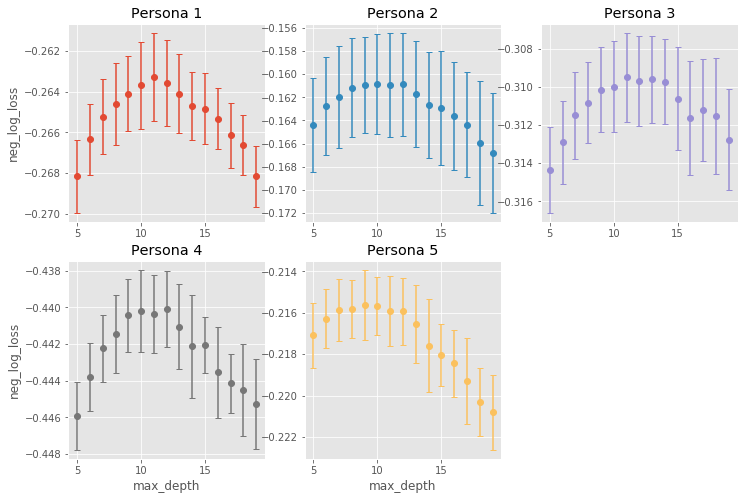

In [17]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_rfg_p = cv_rfg.xs(p, level='persona')
        axs[i//3,i%3].errorbar(cv_rfg_p['params'].map(lambda d: d['max_depth']), 
                               cv_rfg_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_rfg_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('max_depth')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [18]:
rfg_best_params = cv_rfg.loc[cv_rfg['rank_test_score']==1,'params'].reset_index(level=1, drop=True).to_dict()
rfg_best_params

{1: {'max_depth': 11},
 2: {'max_depth': 10},
 3: {'max_depth': 11},
 4: {'max_depth': 12},
 5: {'max_depth': 9}}

In [15]:
rf_best_params

{1: {'max_depth': 11},
 2: {'max_depth': 9},
 3: {'max_depth': 13},
 4: {'max_depth': 10},
 5: {'max_depth': 8}}

In [19]:
rf_max_depth = {1: 11, 2: 10, 3: 11, 4: 12, 5: 9}

rfgs = rf_train_df.groupby('persona').apply(
    lambda g: part_fit_model(g[rf_features].dropna(axis=1, how='all'), 
                             g['target_shopped_ind'], RandomForestClassifier, 
                             n_estimators=200, random_state=2301+g.name, 
                             n_jobs=-1, oob_score=True, criterion='gini',
                             max_depth=rf_max_depth[g.name]) #**rf_best_params[g.name])
    ).to_dict()

In [22]:
rfg_scores = rf_test_df.groupby('persona').apply(
    lambda g: part_score_model(g[rf_features].dropna(axis=1, how='all'), 
                               g['target_shopped_ind'], rfgs[g.name])
    )

In [24]:
rfg_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.904267,0.906200,0.602837,0.059192,0.262063,0.795120
2,15000.0,0.947933,0.950133,0.657143,0.088348,0.163146,0.818129
3,15000.0,0.888333,0.890400,0.637168,0.042985,0.309753,0.742323
4,15000.0,0.768533,0.801400,0.659961,0.292915,0.443846,0.781808
5,15000.0,0.932333,0.932800,0.612903,0.018719,0.219467,0.745327


In [25]:
%%time 

rf_param_grid = {'max_depth': range(5,20)}

cv_rfe = slow_apply(rf_train_df.groupby('persona'), 
                    lambda g: part_grid_search(g[rf_features].dropna(axis=1, how='all'), 
                                               g['target_shopped_ind'], 
                                               RandomForestClassifier, rf_param_grid, g.name, 
                                               scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                               n_estimators=200, criterion='entropy'))

1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
2 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
3 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
 

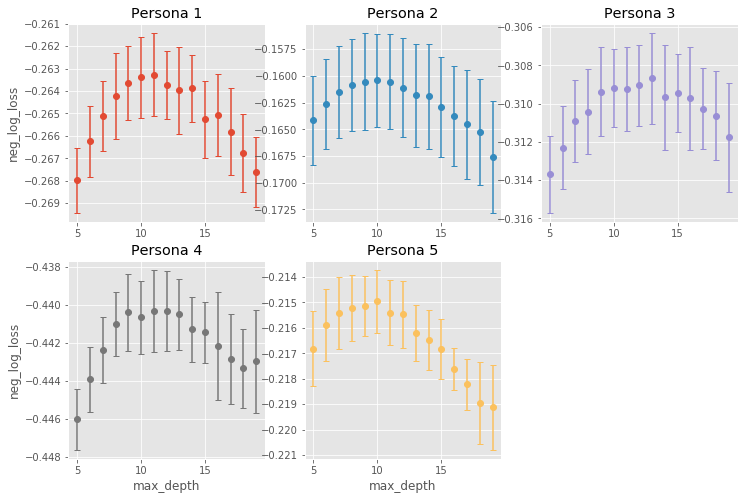

In [26]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_rfe_p = cv_rfe.xs(p, level='persona')
        axs[i//3,i%3].errorbar(cv_rfe_p['params'].map(lambda d: d['max_depth']), 
                               cv_rfe_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_rfe_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('max_depth')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [28]:
rfe_best_params = cv_rfe.loc[cv_rfe['rank_test_score']==1,'params'].reset_index(level=1, drop=True).to_dict()
rfe_best_params

{1: {'max_depth': 11},
 2: {'max_depth': 10},
 3: {'max_depth': 13},
 4: {'max_depth': 11},
 5: {'max_depth': 10}}

In [29]:
#rf_max_depth = {1: 11, 2: 10, 3: 11, 4: 12, 5: 9}

rfes = rf_train_df.groupby('persona').apply(
    lambda g: part_fit_model(g[rf_features].dropna(axis=1, how='all'), 
                             g['target_shopped_ind'], RandomForestClassifier, 
                             n_estimators=200, random_state=2351+g.name, 
                             n_jobs=-1, oob_score=True, criterion='entropy',
                             **rfe_best_params[g.name])
    ).to_dict()

In [30]:
rfe_scores = rf_test_df.groupby('persona').apply(
    lambda g: part_score_model(g[rf_features].dropna(axis=1, how='all'), 
                               g['target_shopped_ind'], rfes[g.name])
    )

In [31]:
rfe_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.904267,0.907133,0.650350,0.064763,0.261745,0.795477
2,15000.0,0.947933,0.950200,0.673469,0.084507,0.162982,0.819091
3,15000.0,0.888333,0.891067,0.688073,0.044776,0.308769,0.743519
4,15000.0,0.768533,0.801267,0.661833,0.289171,0.442909,0.783069
5,15000.0,0.932333,0.932733,0.600000,0.017734,0.218496,0.749516


In [32]:
%%time 

lr_param_grid = {'alpha': np.logspace(-5,-1,5), 
                 'l1_ratio': np.linspace(0,1,11)}

cv_sgd = slow_apply(lr_train_df.groupby('persona'), 
                    lambda g: part_grid_search(g[lr_features].dropna(axis=1, how='all'), 
                                               g['target_shopped_ind'], 
                                               SGDClassifier, lr_param_grid, g.name, 
                                               scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                               loss='log', penalty='elasticnet', 
                                               max_iter=1000))

1 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.2, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)


/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


2 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.5, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
3 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.1, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
4 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.4, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)
5 SGDClass

In [33]:
sgd_best_params = cv_sgd.loc[cv_sgd['rank_test_score'] == 1,'params'].reset_index(level=1, drop=True).to_dict()

In [34]:
sgd_best_params

{1: {'alpha': 0.001, 'l1_ratio': 0.2},
 2: {'alpha': 0.001, 'l1_ratio': 0.5},
 3: {'alpha': 0.001, 'l1_ratio': 0.1},
 4: {'alpha': 0.001, 'l1_ratio': 0.4},
 5: {'alpha': 0.001, 'l1_ratio': 0.4}}

In [30]:
sgd_best_params_orig = cv_sgd.loc[cv_sgd['rank_test_score'] == 1,'params'].reset_index(level=1, drop=True).to_dict()

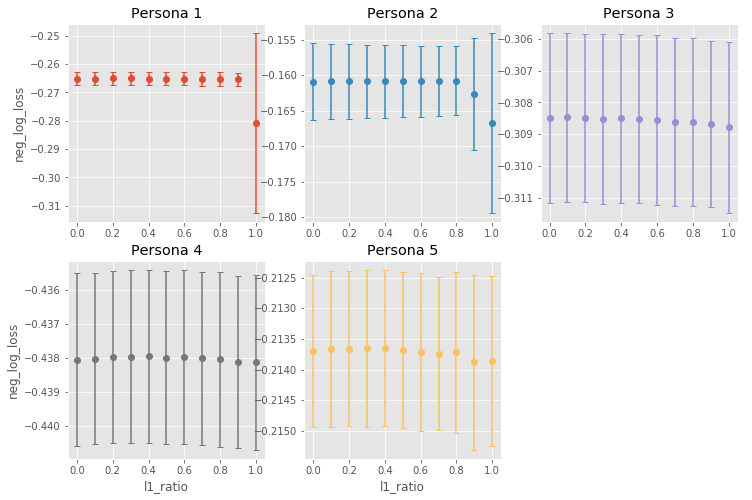

In [35]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_sgd_p = cv_sgd.xs(p, level='persona')
        cv_sgd_p = cv_sgd_p.loc[cv_sgd_p['params'].map(lambda d: d['alpha']) == sgd_best_params[p]['alpha']]
        axs[i//3,i%3].errorbar(cv_sgd_p['params'].map(lambda d: d['l1_ratio']), 
                               cv_sgd_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_sgd_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('l1_ratio')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

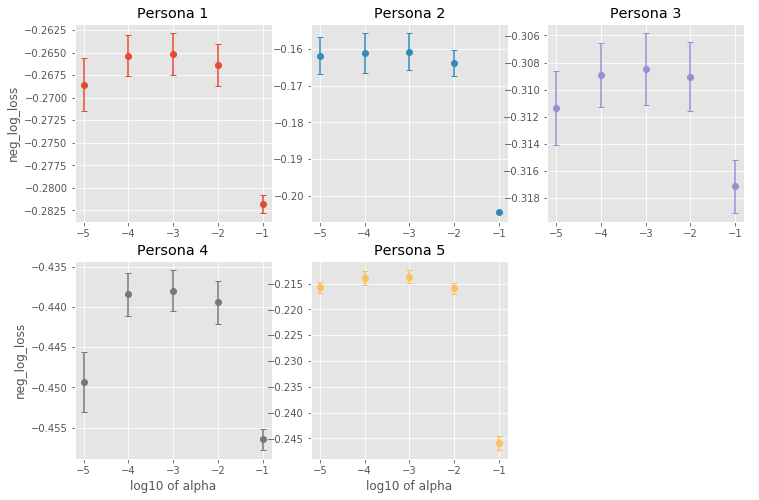

In [36]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_sgd_p = cv_sgd.xs(p, level='persona')
        cv_sgd_p = cv_sgd_p.loc[cv_sgd_p['params'].map(lambda d: d['l1_ratio']) == sgd_best_params[p]['l1_ratio']]
        axs[i//3,i%3].errorbar(np.log10(cv_sgd_p['params'].map(lambda d: d['alpha'])), 
                               cv_sgd_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_sgd_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('log10 of alpha')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [37]:
sgdcs = lr_train_df.groupby('persona').apply(
    lambda g: part_fit_model(g[lr_features].dropna(axis=1, how='all'), 
                             g['target_shopped_ind'], SGDClassifier, 
                             loss='log', penalty='elasticnet', max_iter=1000, 
                             random_state=3301+g.name, n_jobs=-1, 
                             alpha=0.001, l1_ratio=0.4)
                             #**sgd_best_params[g.name])
    ).to_dict()

In [38]:
lr_scores = lr_test_df.groupby('persona').apply(
    lambda g: part_score_model(g[lr_features].dropna(axis=1, how='all'), 
                               g['target_shopped_ind'], sgdcs[g.name])
    )

In [39]:
lr_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.904267,0.905933,0.555066,0.087744,0.263876,0.790237
2,15000.0,0.947933,0.949867,0.578378,0.137004,0.164402,0.817328
3,15000.0,0.888333,0.891533,0.630435,0.069254,0.307976,0.744744
4,15000.0,0.768533,0.801467,0.637989,0.328917,0.442742,0.782943
5,15000.0,0.932333,0.932933,0.567164,0.037438,0.216702,0.759747


In [12]:
%%time 

lc_param_grid = {'C': np.logspace(-3,3,7)}

cv_lc = slow_apply(lr_train_df.groupby('persona'), 
                    lambda g: part_grid_search(g[lr_features].dropna(axis=1, how='all'), 
                                               g['target_shopped_ind'], 
                                               LogisticRegression, lc_param_grid, g.name, 
                                               scoring='neg_log_loss', cv=5, n_jobs=-1,
                                               penalty='l1', solver='saga'))

1 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)


/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/c01f/.virtualenvs/devel/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/c0

2 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
3 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
4 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
5 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol

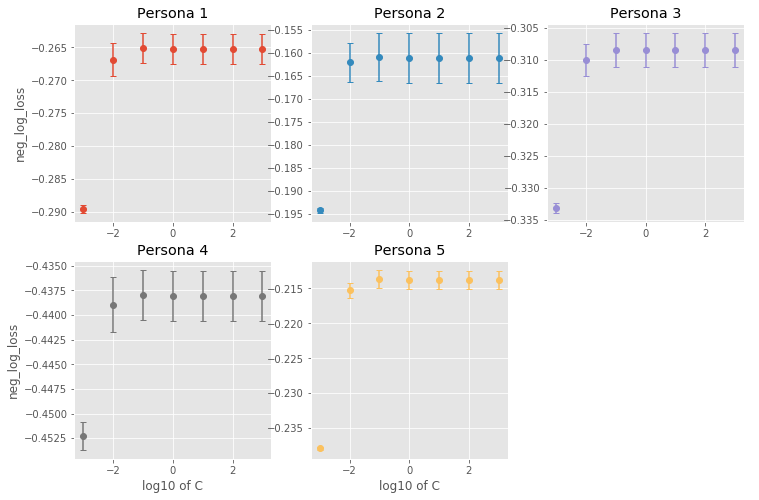

In [13]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_lc_p = cv_lc.xs(p, level='persona')
        axs[i//3,i%3].errorbar(np.log10(cv_lc_p['params'].map(lambda d: d['C'])), 
                               cv_lc_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_lc_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('log10 of C')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [14]:
lc_best_params = cv_lc.loc[cv_lc['rank_test_score']==1,'params'].reset_index(level=1, drop=True).to_dict()

In [15]:
lcs = lr_train_df.groupby('persona').apply(
    lambda g: part_fit_model(g[lr_features].dropna(axis=1, how='all'), 
                             g['target_shopped_ind'], LogisticRegression, 
                             penalty='l1', solver='saga',
                             random_state=4301+g.name, n_jobs=-1, 
                             C = 0.1) #**lc_best_params[g.name])
    ).to_dict()

In [30]:
lc_scores = lr_test_df.groupby('persona').apply(
    lambda g: part_score_model(g[lr_features].dropna(axis=1, how='all'), 
                               g['target_shopped_ind'], lcs[g.name])
    )

In [31]:
lc_scores

,n,null_accuracy,accuracy,precision,recall,bal_accuracy,log_loss,roc_auc
persona,,,,,,,,
1,15000.0,0.904267,0.905867,0.551724,0.089136,0.540735,0.263759,0.790009
2,15000.0,0.947933,0.949800,0.573684,0.139565,0.566934,0.164483,0.817277
3,15000.0,0.888333,0.891400,0.623656,0.069254,0.532000,0.307934,0.744595
4,15000.0,0.768533,0.801400,0.637326,0.329493,0.636511,0.442773,0.782941
5,15000.0,0.932333,0.932800,0.553846,0.035468,0.516697,0.216668,0.759900


In [18]:
%%time 

gb_param_grid = {'max_depth': range(2,7)}

cv_gb = slow_apply(rf_train_df.groupby('persona'), 
                   lambda g: part_grid_search(g[rf_features].dropna(axis=1, how='all'), 
                                              g['target_shopped_ind'], 
                                              GradientBoostingClassifier, gb_param_grid, g.name, 
                                              scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                              n_estimators=500, learning_rate=0.02))

1 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
2 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
3 GradientBoostingClassifier(criterion='friedman_mse

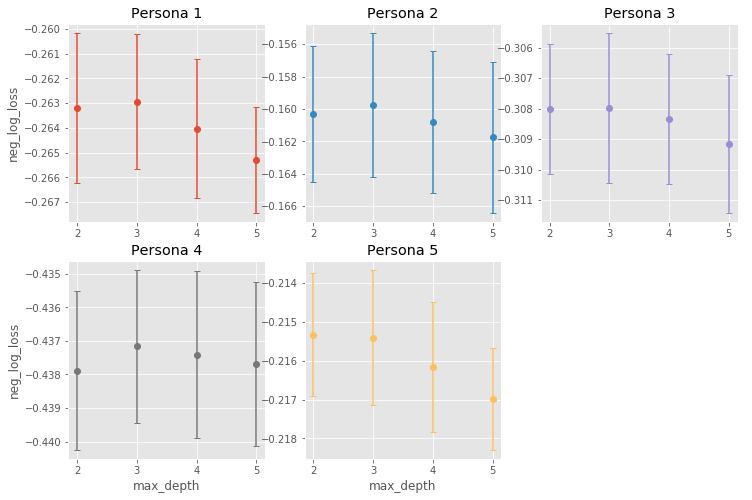

In [19]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_gb_p = cv_gb.xs(p, level='persona')
        axs[i//3,i%3].errorbar(cv_gb_p['params'].map(lambda d: d['max_depth']), 
                               cv_gb_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_gb_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('max_depth')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [20]:
gb_best_params = cv_gb.loc[cv_gb['rank_test_score']==1,'params'].reset_index(level=1, drop=True).to_dict()
#gb_max_depth = {1: 2, 2: 2, 3: 3, 4: 2, 5: 2}

gbcs = rf_train_df.groupby('persona').apply(
    lambda g: part_fit_model(g[rf_features].dropna(axis=1, how='all'), 
                             g['target_shopped_ind'], GradientBoostingClassifier, 
                             n_estimators=500, learning_rate=0.02, 
                             random_state=5301+g.name, max_depth=3) #**gb_best_params[g.name])
    ).to_dict()

In [32]:
gb_scores = rf_test_df.groupby('persona').apply(
    lambda g: part_score_model(g[rf_features].dropna(axis=1, how='all'), 
                               g['target_shopped_ind'], gbcs[g.name])
    )

In [33]:
gb_scores

,n,null_accuracy,accuracy,precision,recall,bal_accuracy,log_loss,roc_auc
persona,,,,,,,,
1,15000.0,0.904267,0.906733,0.587678,0.086351,0.539968,0.260287,0.800081
2,15000.0,0.947933,0.949667,0.573864,0.129321,0.562023,0.163618,0.819397
3,15000.0,0.888333,0.891333,0.610837,0.074030,0.534051,0.307812,0.747425
4,15000.0,0.768533,0.802600,0.648633,0.321141,0.634373,0.441350,0.784895
5,15000.0,0.932333,0.932600,0.523256,0.044335,0.520702,0.218198,0.753928


In [35]:
%%time 

gb_param_grid = {'max_depth': range(2,7)}

cv_gbss = slow_apply(rf_train_df.groupby('persona'), 
                     lambda g: part_grid_search(g[rf_features].dropna(axis=1, how='all'), 
                                                g['target_shopped_ind'], 
                                                GradientBoostingClassifier, gb_param_grid, g.name, 
                                                scoring='neg_log_loss', cv=5, n_jobs=-1, 
                                                n_estimators=500, learning_rate=0.02, subsample=0.7))

1 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.7, verbose=0,
              warm_start=False)
2 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.7, verbose=0,
              warm_start=False)
3 GradientBoostingClassifier(criterion='friedman_mse

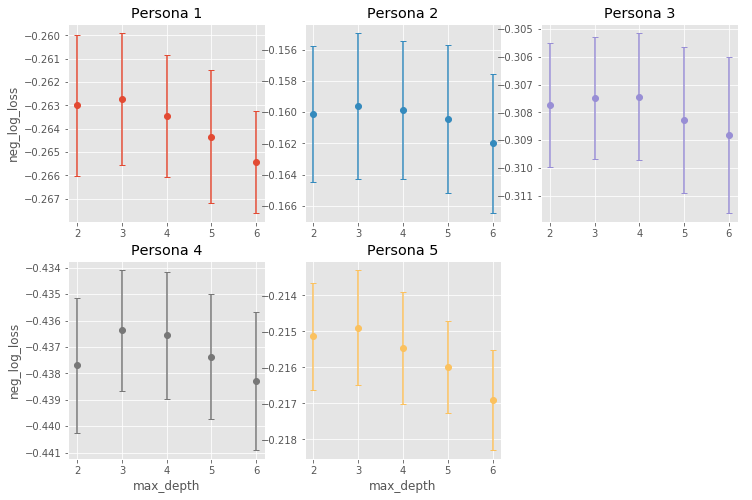

In [36]:
fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
palette = sns.color_palette()

for i in xrange(6):
    p = i+1
    try: 
        cv_gbss_p = cv_gbss.xs(p, level='persona')
        axs[i//3,i%3].errorbar(cv_gbss_p['params'].map(lambda d: d['max_depth']), 
                               cv_gbss_p['mean_test_score'], 
                               fmt='o', 
                               capsize=3, 
                               yerr=cv_gbss_p['std_test_score'], 
                               color=palette[i])
        axs[i//3,i%3].set_title('Persona {}'.format(p))
    except KeyError:
        axs[i//3,i%3].set_axis_off()
    if i//3 == 1:
        axs[i//3,i%3].set_xlabel('max_depth')
    if i%3 == 0:
        axs[i//3,i%3].set_ylabel('neg_log_loss')

In [37]:
gbss_best_params = cv_gbss.loc[cv_gbss['rank_test_score']==1,'params'].reset_index(level=1, drop=True).to_dict()
#gbss_max_depth = {1: 2, 2: 2, 3: 3, 4: 2, 5: 2}

gbsss = rf_train_df.groupby('persona').apply(
    lambda g: part_fit_model(g[rf_features].dropna(axis=1, how='all'), 
                             g['target_shopped_ind'], GradientBoostingClassifier, 
                             n_estimators=500, learning_rate=0.02, subsample=0.7,
                             random_state=5301+g.name, max_depth=3) #**gb_best_params[g.name])
    ).to_dict()

In [38]:
gbss_scores = rf_test_df.groupby('persona').apply(
    lambda g: part_score_model(g[rf_features].dropna(axis=1, how='all'), 
                               g['target_shopped_ind'], gbsss[g.name])
    )

In [39]:
gbss_scores

,n,null_accuracy,accuracy,precision,recall,bal_accuracy,log_loss,roc_auc
persona,,,,,,,,
1,15000.0,0.904267,0.907067,0.592920,0.093315,0.543266,0.260013,0.800227
2,15000.0,0.947933,0.950467,0.604396,0.140845,0.567891,0.163054,0.820261
3,15000.0,0.888333,0.892333,0.642857,0.080597,0.537484,0.307109,0.749374
4,15000.0,0.768533,0.802467,0.643380,0.328917,0.637004,0.440495,0.786040
5,15000.0,0.932333,0.932667,0.530120,0.043350,0.520281,0.218044,0.754727


In [40]:
gb_scores

,n,null_accuracy,accuracy,precision,recall,bal_accuracy,log_loss,roc_auc
persona,,,,,,,,
1,15000.0,0.904267,0.906733,0.587678,0.086351,0.539968,0.260287,0.800081
2,15000.0,0.947933,0.949667,0.573864,0.129321,0.562023,0.163618,0.819397
3,15000.0,0.888333,0.891333,0.610837,0.074030,0.534051,0.307812,0.747425
4,15000.0,0.768533,0.802600,0.648633,0.321141,0.634373,0.441350,0.784895
5,15000.0,0.932333,0.932600,0.523256,0.044335,0.520702,0.218198,0.753928


In [41]:
lc_scores

,n,null_accuracy,accuracy,precision,recall,bal_accuracy,log_loss,roc_auc
persona,,,,,,,,
1,15000.0,0.904267,0.905867,0.551724,0.089136,0.540735,0.263759,0.790009
2,15000.0,0.947933,0.949800,0.573684,0.139565,0.566934,0.164483,0.817277
3,15000.0,0.888333,0.891400,0.623656,0.069254,0.532000,0.307934,0.744595
4,15000.0,0.768533,0.801400,0.637326,0.329493,0.636511,0.442773,0.782941
5,15000.0,0.932333,0.932800,0.553846,0.035468,0.516697,0.216668,0.759900


In [30]:
rf_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.903267,0.905667,0.618421,0.064783,0.261488,0.799899
2,15000.0,0.949667,0.951533,0.655556,0.078146,0.158246,0.824912
3,15000.0,0.889933,0.892467,0.621795,0.058752,0.303034,0.752483
4,15000.0,0.773533,0.807200,0.656735,0.311451,0.434736,0.787185
5,15000.0,0.934067,0.934200,0.529412,0.018200,0.213529,0.755827


In [31]:
gb_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.903267,0.906333,0.593496,0.100620,0.260611,0.802885
2,15000.0,0.949667,0.950467,0.538462,0.111258,0.158659,0.823638
3,15000.0,0.889933,0.891200,0.535581,0.086614,0.302628,0.753432
4,15000.0,0.773533,0.806333,0.633406,0.343833,0.433845,0.788727
5,15000.0,0.934067,0.934333,0.531250,0.034378,0.213300,0.760546


In [23]:
lc_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.903267,0.906067,0.587500,0.097174,0.264149,0.794464
2,15000.0,0.949667,0.951467,0.609756,0.099338,0.158590,0.824422
3,15000.0,0.889933,0.892200,0.567460,0.086614,0.302220,0.753532
4,15000.0,0.773533,0.805133,0.627010,0.344422,0.433446,0.788961
5,15000.0,0.934067,0.935133,0.621212,0.041456,0.210941,0.767439


In [32]:
lr_scores

,n,null_accuracy,accuracy,precision,recall,log_loss,roc_auc
persona,,,,,,,
1,15000.0,0.903267,0.905867,0.585903,0.091661,0.264300,0.794437
2,15000.0,0.949667,0.951467,0.604651,0.103311,0.158680,0.824050
3,15000.0,0.889933,0.891733,0.544850,0.099334,0.302553,0.753233
4,15000.0,0.773533,0.805467,0.633575,0.334413,0.433710,0.788511
5,15000.0,0.934067,0.934933,0.603175,0.038423,0.211098,0.767788


In [22]:
xdf = pd.read_csv('../data/ep_{0}_data_summary.csv'.format(key_event_slug), index_col='persona')
xdf

,n,n_pos
persona,,
1,1766814,169019
2,2188483,110209
3,7760758,843944
4,3899887,888168
5,1748052,115534


In [30]:
np.shape(xdf)[1]

2

In [27]:
lr_train_df.groupby('persona').apply(lambda g: len(g[lr_features].dropna(axis=1, how='all').columns))

persona
1    43
2    37
3    49
4    49
5    42
dtype: int64

In [24]:
rf_train_df.groupby('persona').apply(lambda g: len(g[rf_features].dropna(axis=1, how='all').columns))

persona
1    42
2    37
3    42
4    42
5    42
dtype: int64

In [42]:
import pickle

In [33]:
#rfcs
#sgdcs

In [41]:
with open('../data/ep_{0}_randomforest_model.pkl'.format(key_event_slug), 'wb') as f:
    pickle.dump(rfcs, f)

In [40]:
with open('../data/ep_{0}_stochgraddesc_model.pkl'.format(key_event_slug), 'wb') as g:
    pickle.dump(sgdcs, g)

In [43]:
with open('../data/ep_{0}_logisticreg_model.pkl'.format(key_event_slug), 'wb') as f:
    pickle.dump(lcs, f)

In [44]:
with open('../data/ep_{0}_gradboost_model.pkl'.format(key_event_slug), 'wb') as f:
    pickle.dump(gbcs, f)

In [45]:
with open('../data/ep_{0}_gbsubsample_model.pkl'.format(key_event_slug), 'wb') as f:
    pickle.dump(gbsss, f)